In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [64]:
n_embed = 10
n_hidden = 200
vocab_size = 27

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/ ((n_embed * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Make a batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  h = torch.tanh(hpreact)

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break



      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


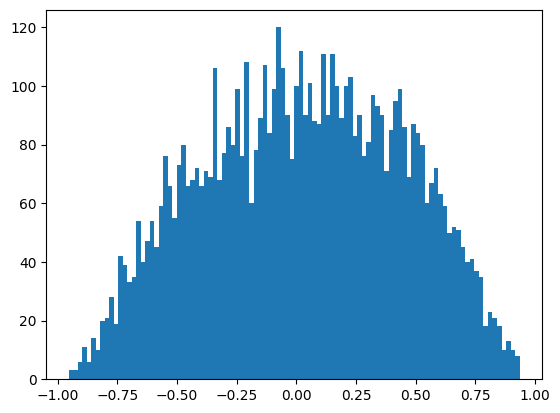

In [48]:
plt.hist(h.view(-1).tolist(), 100);

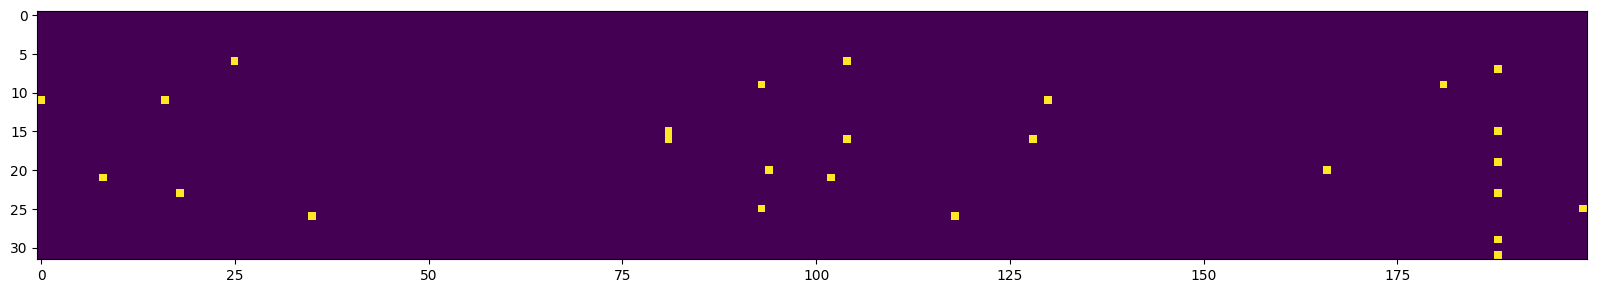

In [49]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.90, interpolation='nearest')

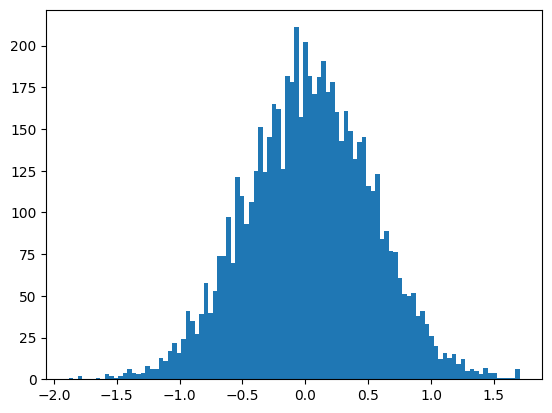

In [50]:
plt.hist(hpreact.view(-1).tolist(), 100);

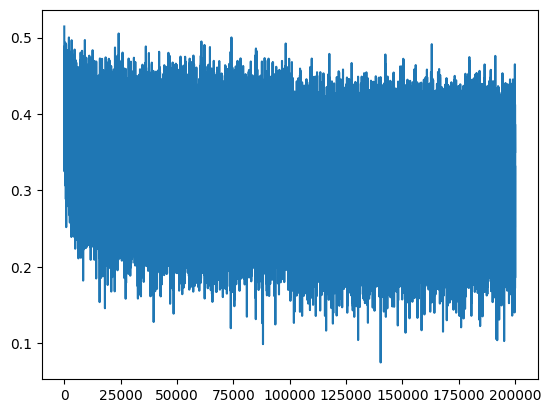

In [53]:
plt.plot(lossi)

In [69]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.06659197807312
val 2.1050572395324707


In [55]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

carlah.
ambrie.
khy.
mili.
tatyah.
cassie.
rahnee.
deliah.
jarqui.
nellara.
chaiir.
kaleigh.
ham.
join.
quinthanourta.
jadiquinterri.
jaryxia.
kaellinsleee.
deciia.
gilee.


In [59]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0085) tensor(0.9992)
tensor(1.3792e-05) tensor(1.0021)


In [126]:
# Pytorch-ify the whole thing:

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight, self.bias] if self.bias is not None else [self.weight]
  
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    self [self.gamma, self.beta]


class Tanh:
  def __init__(self):
    pass

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

n_embed = 10  # number of dimensions of the embedding
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
  Linear(n_embed * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # Make last layer less confident for better training
  #layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True



46497


In [127]:
# Run the training now :)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # Backwards
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < max_steps / 2 else 0.01
  # Update parameters
  for p in parameters:
    p.data += -lr * p.grad

  # print(i)
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())
  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG

      0/ 200000: 3.2962


layer 1 (<class '__main__.Tanh'>): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (<class '__main__.Tanh'>): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (<class '__main__.Tanh'>): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (<class '__main__.Tanh'>): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (<class '__main__.Tanh'>): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

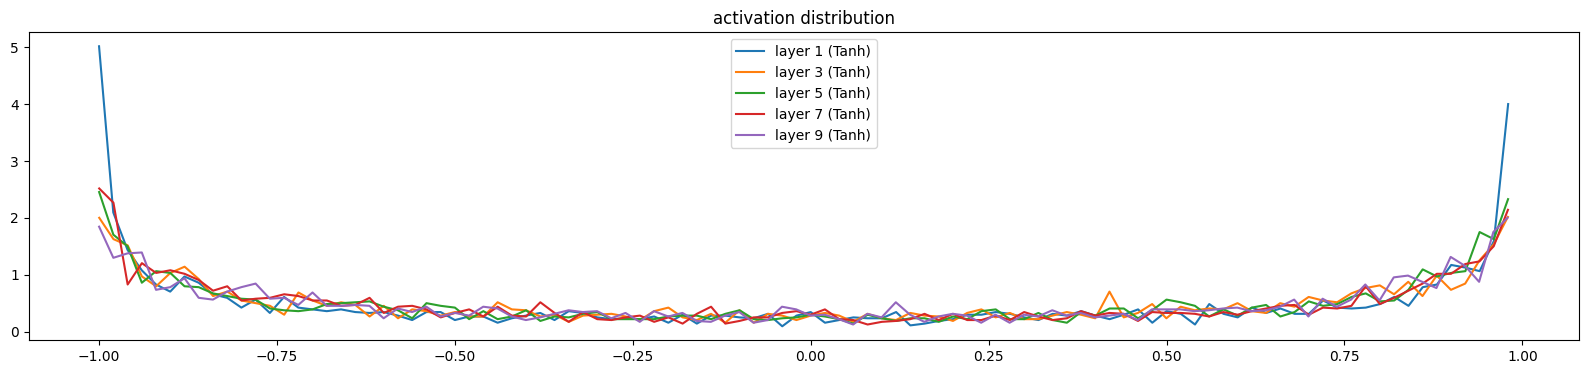

In [128]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (<class '__main__.Tanh'>): mean 0.000024, std 3.353992e-03
layer 3 (<class '__main__.Tanh'>): mean 0.000012, std 3.157345e-03
layer 5 (<class '__main__.Tanh'>): mean -0.000004, std 2.925863e-03
layer 7 (<class '__main__.Tanh'>): mean 0.000036, std 2.715700e-03
layer 9 (<class '__main__.Tanh'>): mean 0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

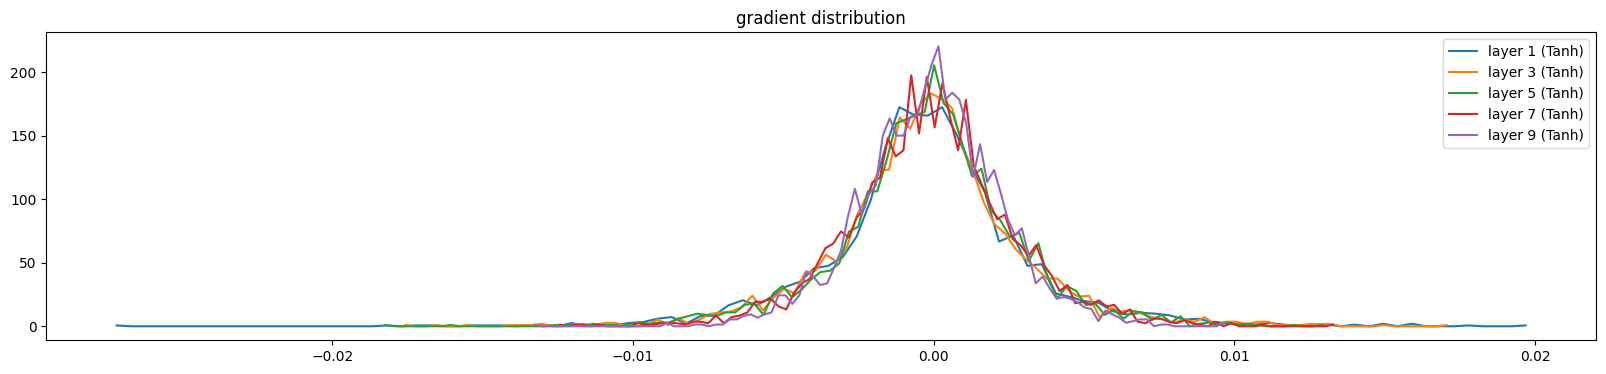

In [129]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %f, std %e' % (i, layer.__class__, t.mean(), t.std(),))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02
weight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075621e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


Text(0.5, 1.0, 'weights gradient distribution')

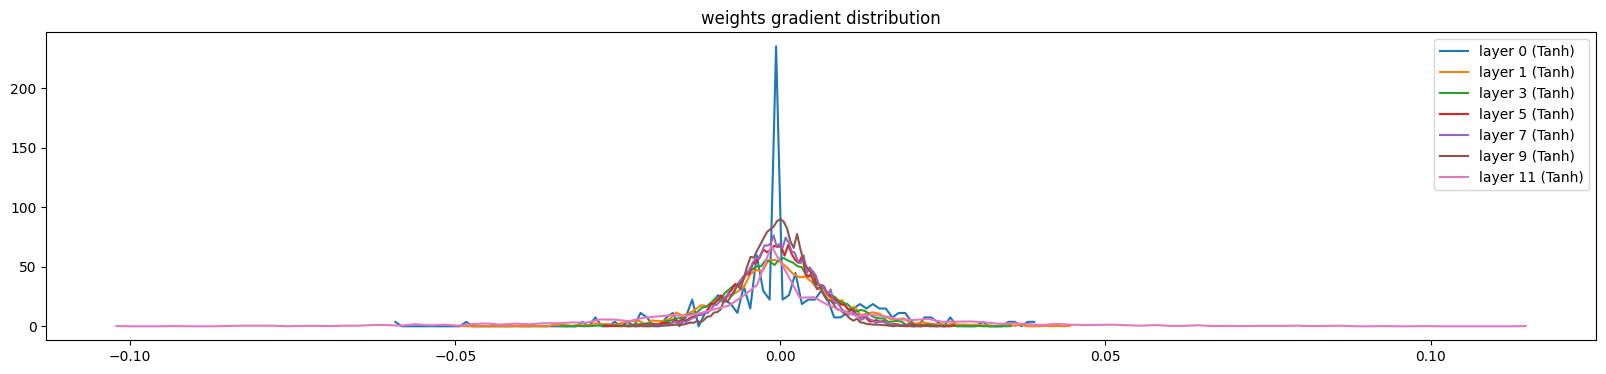

In [130]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights gradient distribution')

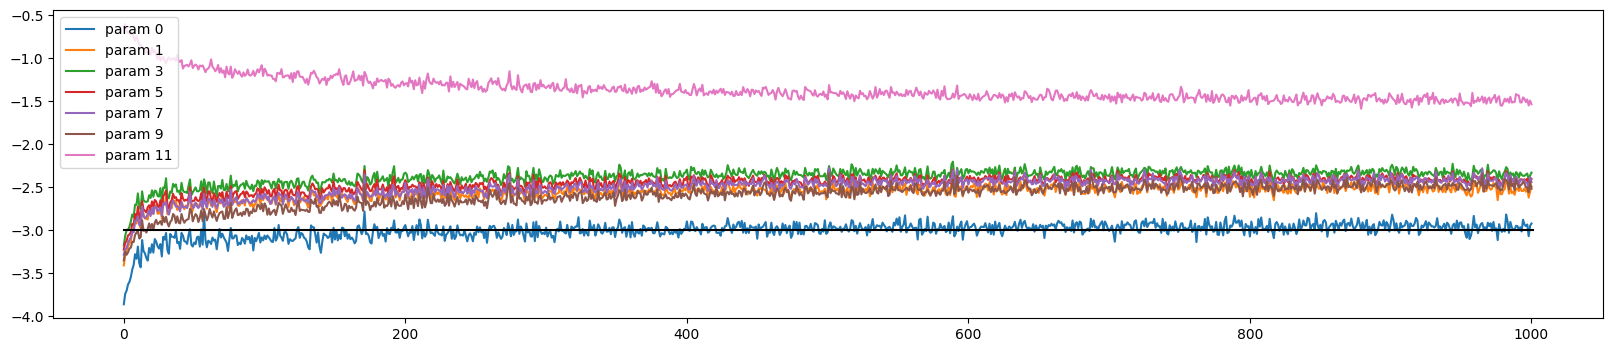

In [131]:
# Plot learning rates over time
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # 1e-3 is a good learning rate
plt.legend(legends)

In [88]:
torch.sum(t > 0.99)

tensor(424)

In [91]:
t.numel()

3200